# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST
from sklearn.metrics import precision_recall_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [2]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


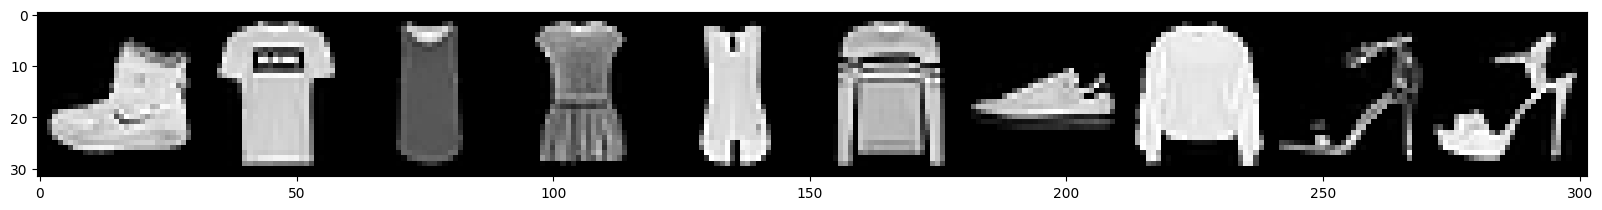

In [3]:
x = [train_dataset[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

## Model

In [4]:
# From Traning-Example Notebook
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Training

In [5]:
?F.nll_loss

Signature:
F.nll_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
) -> torch.Tensor
Docstring:
Compute the negative log likelihood loss.

See :class:`~torch.nn.NLLLoss` for details.

Args:
    input: :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
        in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
        in the case of K-dimensional loss. `input` is expected to be log-probabilities.
    target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
        or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
        K-dimensional loss.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): Deprecated (see :attr

In [208]:
def train(model, device, loader, optimizer, loss_fn, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        # Debug:
        # print(target.shape)
        # print(data.shape)

        optimizer.zero_grad()
        output = model(data)
        # print(output.shape)
        loss = loss_fn(output, target)
        # print("Real class:", target.shape)
        # print("Predicted class:", output.argmax(dim=1, keepdim=True).squeeze())
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()), end='\r')


def test(model, device, loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output.shape)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)), end='\r')

In [7]:
model = Net()
model.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
?torch.optim.lr_scheduler.StepLR

Init signature:
torch.optim.lr_scheduler.StepLR(
    optimizer: torch.optim.optimizer.Optimizer,
    step_size: int,
    gamma: float = 0.1,
    last_epoch: int = -1,
)
Docstring:     
Decays the learning rate of each parameter group by gamma every step_size epochs.

Notice that such decay can happen simultaneously with other changes to the learning rate
from outside this scheduler. When last_epoch=-1, sets initial lr as lr.

Args:
    optimizer (Optimizer): Wrapped optimizer.
    step_size (int): Period of learning rate decay.
    gamma (float): Multiplicative factor of learning rate decay.
        Default: 0.1.
    last_epoch (int): The index of last epoch. Default: -1.

Example:
    >>> # xdoctest: +SKIP
    >>> # Assuming optimizer uses lr = 0.05 for all groups
    >>> # lr = 0.05     if epoch < 30
    >>> # lr = 0.005    if 30 <= epoch < 60
    >>> # lr = 0.0005   if 60 <= epoch < 90
    >>> # ...
    >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    >>> for epoch in 

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, loss_fn, epoch)
    test(model, device, test_loader, loss_fn)
    scheduler.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 13.723047
Test set: Average loss: 0.3511, Accuracy: 8714/10000 (87%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 30.239885
Test set: Average loss: 0.2976, Accuracy: 8890/10000 (89%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 14.633139
Test set: Average loss: 0.2706, Accuracy: 9022/10000 (90%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 13.020397
Test set: Average loss: 0.2583, Accuracy: 9039/10000 (90%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 21.457800
Test set: Average loss: 0.2405, Accuracy: 9139/10000 (91%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 18.087008
Test set: Average loss: 0.2290, Accuracy: 9177/10000 (92%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 6.1748616
Test set: Average loss: 0.2257, Accuracy: 9192/10000 (92%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 13.583120
Test set: Average loss: 0.2239, Accuracy: 9205/10000 (92%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 12.034758
Test set: Average loss: 0.2240, Accuracy: 9212/10000 (92%)
Train Epoc

## Evaluation
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

### Confusion Matrix in shape 10x10 foir each class

In [10]:
type(test_dataset)

torchvision.datasets.mnist.FashionMNIST

In [11]:
dir(torchvision.datasets.mnist.FashionMNIST)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_check_legacy_exist',
 '_format_transform_repr',
 '_is_protocol',
 '_load_data',
 '_load_legacy_data',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'download',
 'extra_repr',
 'mirrors',
 'processed_folder',
 'raw_folder',
 'resources',
 'test_data',
 'test_file',
 'test_labels',
 'train_data',
 'train_labels',
 'training_file']

In [12]:
test_dataset.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

Text(0, 0.5, 'True Label')

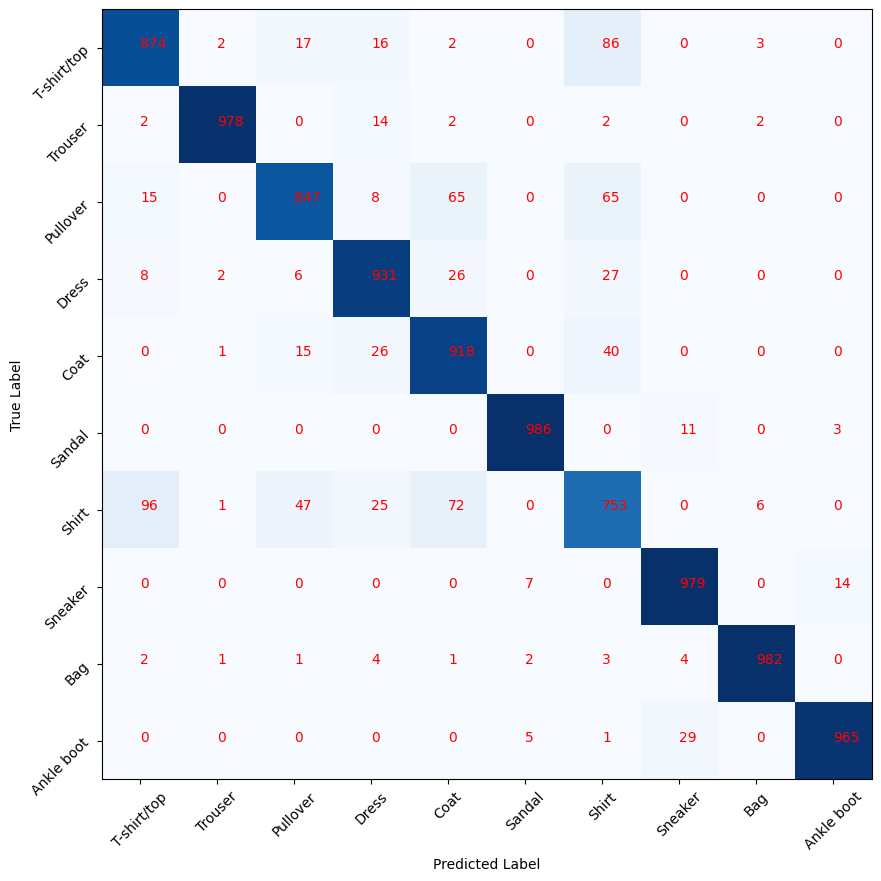

In [13]:
confusion_matrix = torch.zeros(10, 10)
# Y: True Label
# X: Predicted Label

model.eval()
# Iterate over all images in test_set
for data, target in test_dataset:
    data = data.to(device)
    # print(data.shape)
    output = model(data.unsqueeze(0))
    pred = output.argmax(dim=1, keepdim=True)
    # print(f"target: {target} has prediction {pred}")
    confusion_matrix[target][pred.to("cpu")] += 1

# Plot matrix
plt.figure(figsize=(10,10))
plt.xticks(range(10), [idx_to_class[i] for i in range(10)], rotation=45)
plt.yticks(range(10), [idx_to_class[i] for i in range(10)], rotation=45)
for i in range(10):
    for j in range(10):
        plt.text(j,i, int(confusion_matrix[i][j]), color="red")

plt.imshow(confusion_matrix, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## Accuracy, Precision, Recall and F1 using the maximum response

In [14]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model.eval()
model.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2 = 2* (precision_matrix * recall_matric) / (precision_matrix + recall_matric)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.37%
  Precision for: 87.66%
  Recall for: 87.4%
  F1 Score: 87.53%

Trouser
  Accuracy for: 99.69%
  Precision for: 99.29%
  Recall for: 97.8%
  F1 Score: 98.54%

Pullover
  Accuracy for: 97.47%
  Precision for: 90.78%
  Recall for: 84.7%
  F1 Score: 87.64%

Dress
  Accuracy for: 98.27%
  Precision for: 90.92%
  Recall for: 93.1%
  F1 Score: 92.0%

Coat
  Accuracy for: 97.36%
  Precision for: 84.53%
  Recall for: 91.8%
  F1 Score: 88.02%

Sandal
  Accuracy for: 99.7%
  Precision for: 98.6%
  Recall for: 98.6%
  F1 Score: 98.6%

Shirt
  Accuracy for: 95.14%
  Precision for: 77.07%
  Recall for: 75.3%
  F1 Score: 76.18%

Sneaker
  Accuracy for: 99.3%
  Precision for: 95.7%
  Recall for: 97.9%
  F1 Score: 96.79%

Bag
  Accuracy for: 99.69%
  Precision for: 98.89%
  Recall for: 98.2%
  F1 Score: 98.54%

Ankle boot
  Accuracy for: 99.44%
  Precision for: 98.27%
  Recall for: 96.5%
  F1 Score: 97.38%



## visualize Precision-Recall curve for different classes 

In [15]:
?precision_recall_curve

Signature:
precision_recall_curve(
    y_true,
    y_score,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=False,
)
Docstring:
Compute precision-recall pairs for different probability thresholds.

Note: this implementation is restricted to the binary classification task.

The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
true positives and ``fp`` the number of false positives. The precision is
intuitively the ability of the classifier not to label as positive a sample
that is negative.

The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
true positives and ``fn`` the number of false negatives. The recall is
intuitively the ability of the classifier to find all the positive samples.

The last precision and recall values are 1. and 0. respectively and do not
have a corresponding threshold. This ensures that the graph starts on the
y axis.

The first precision and recall values are precision=class balance and recall=

Text(0.5, 1.0, "Precision-Recall Curve for classes: ['T-shirt/top', 'Dress', 'Sandal', 'Bag']")

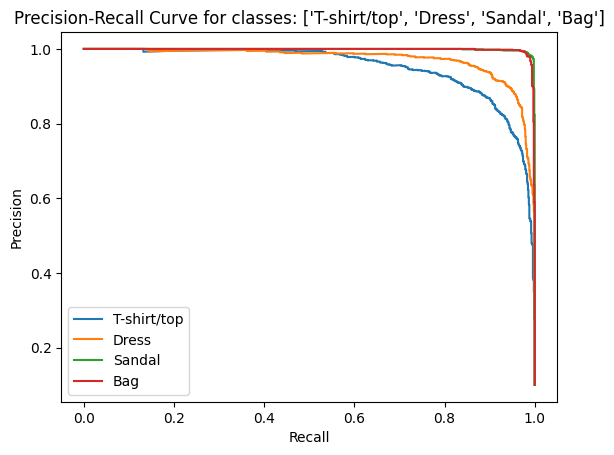

In [16]:
indices = [0,3,5,8]

for i in indices:
    y_true = (test_dataset.targets == i)
    y_scores = []

    model.eval()
    for data, target in test_dataset:
        data = data.to(device)
        out = model(data.unsqueeze(0))
        i_score = out[0][i].item()
        # print(i_score)
        y_scores.append(i_score)
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label=f"{idx_to_class[i]}")

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve for classes: {[idx_to_class[i] for i in indices]}")

## visualize example images with predicted classes

(6, 0, 0, 0, 6)


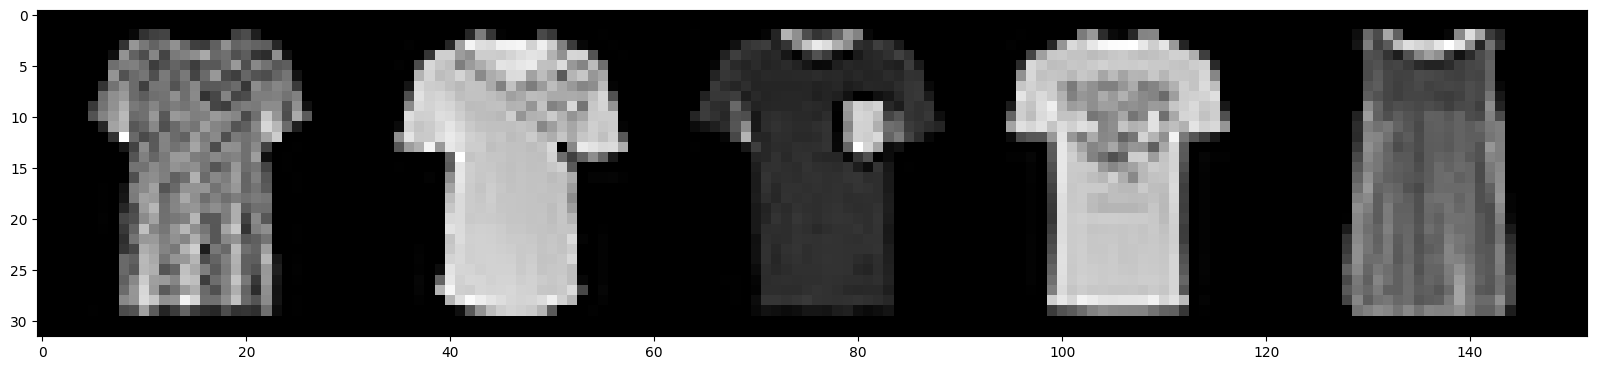

In [17]:
import random 

def visualize_examples(class_idx, amount, dataset = test_dataset):
    predictions = []
    for data, target in test_dataset:
        data = data.to(device)
        out = model(data.unsqueeze(0))
        pred = out.argmax(dim=1, keepdim=True)
        predictions.append(pred.item())

    # Indices with same class
    random_indices = torch.where(torch.tensor(predictions) == class_idx)[0].tolist()
    indices = random.sample(random_indices, amount)

    # From "Training-Example.ipynb"
    x,y = zip(*[dataset[i] for i in indices])
    x = torch.stack(x)

    grid_img = torchvision.utils.make_grid(x, nrow=amount)
    plt.figure(figsize=(20,5))
    plt.imshow(grid_img.permute(1, 2, 0))
    print(y)

visualize_examples(class_idx = 0, amount = 5)

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [160]:
train_dataset_noisy = NoisyFashionMNIST("./data", True)
test_dataset_noisy = NoisyFashionMNIST("./data", False)

In [161]:
test_loader_noisy = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=64, shuffle=False)

In [162]:
train_dataset_noisy.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40884256..1.3146737].


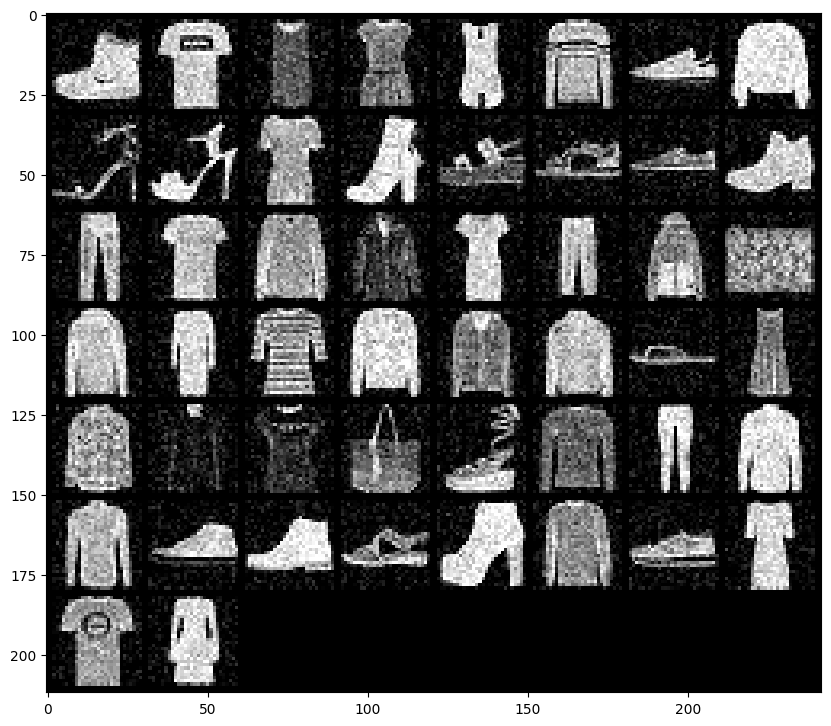

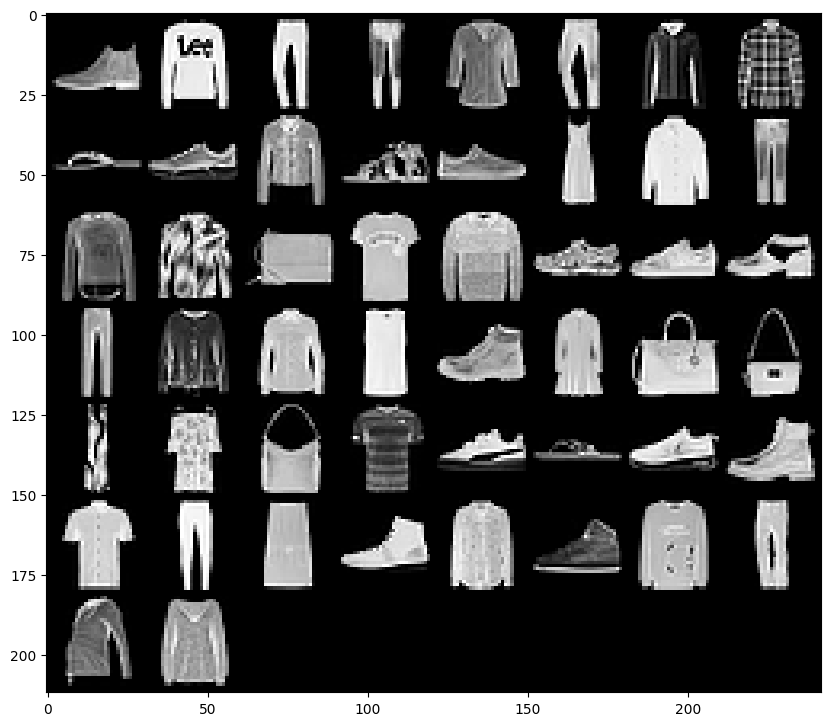

In [163]:
x = [train_dataset_noisy[i][0] for i in range(50)]
y = [test_dataset_noisy[i][1] for i in range(50)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(y))
plt.show()

## Classifier

### Model

In [22]:
model_noisy = Net()
model_noisy.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Train

There is a problem with the `NoisyFashionMNIST` dataset from `utils.py`. It never returns the correct labels but instead `noisy_img, img`. Therefore a new combined dataset is introducted for training which combines the noisy images with the labels.

In [23]:
from torch.utils.data import Dataset

class NoisyWithLabels(Dataset):
    def __init__(self, noisy_dataset):
        self.noisy = noisy_dataset
        self.clean = noisy_dataset.dataset

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, idx):
        noisy_img, original_img = self.noisy[idx]  
        label = self.clean[idx][1]                   # int label from FashionMNIST
        return torch.tensor(noisy_img), torch.tensor(label)

wrapped_train = NoisyWithLabels(train_dataset_noisy)
wrapped_test  = NoisyWithLabels(test_dataset_noisy)

wrapped_train_loader = torch.utils.data.DataLoader(wrapped_train, batch_size=64, shuffle=True)
wrapped_test_loader  = torch.utils.data.DataLoader(wrapped_test,  batch_size=64, shuffle=False)

# Print first 10 of dataset
x = [wrapped_train[i][0] for i in range(10)]
labels = [wrapped_train[i][1] for i in range(10)]
print(labels)

# get from real dataset first 10
x_clean = [train_dataset[i][0] for i in range(10)]
labels_clean = [train_dataset[i][1] for i in range(10)]
print(labels_clean)

[tensor(9), tensor(0), tensor(0), tensor(3), tensor(0), tensor(2), tensor(7), tensor(2), tensor(5), tensor(5)]
[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


C:\Users\Jean\AppData\Local\Temp\ipykernel_28380\358494295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_img), torch.tensor(label)


In [24]:
print("Normal FashionMNIST:")
for data, target in test_loader:
    print(f"Data shape: {data.shape}") 
    print(f"Target shape: {target.shape}")  
    break

print("\nNoisyFashionMNIST:")
for noisy_data, original_data in test_loader_noisy:
    print(f"Noisy Data shape: {noisy_data.shape}") 
    print(f"Original Data shape: {original_data.shape}")
    break

Normal FashionMNIST:
Data shape: torch.Size([64, 1, 28, 28])
Target shape: torch.Size([64])

NoisyFashionMNIST:
Noisy Data shape: torch.Size([64, 1, 28, 28])
Original Data shape: torch.Size([64, 1, 28, 28])


In [97]:
model_noisy = Net().to(device)

In [98]:
optimizer = torch.optim.Adam(model_noisy.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

for epoch in range(1, 11):
    train(model_noisy, device, wrapped_train_loader, optimizer, loss_fn, epoch)
    test(model_noisy, device, wrapped_test_loader, loss_fn)
    scheduler.step()

C:\Users\Jean\AppData\Local\Temp\ipykernel_28380\358494295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_img), torch.tensor(label)


Train Epoch: 1 [59520/60000 (99%)]	Loss: 22.659113
Test set: Average loss: 0.3794, Accuracy: 8587/10000 (86%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 29.386755
Test set: Average loss: 0.3380, Accuracy: 8771/10000 (88%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 22.855381
Test set: Average loss: 0.3168, Accuracy: 8834/10000 (88%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 24.319855
Test set: Average loss: 0.2948, Accuracy: 8919/10000 (89%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 24.123236
Test set: Average loss: 0.2849, Accuracy: 8967/10000 (90%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 25.390642
Test set: Average loss: 0.2716, Accuracy: 9005/10000 (90%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 24.452967
Test set: Average loss: 0.2727, Accuracy: 8995/10000 (90%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 28.730841
Test set: Average loss: 0.2699, Accuracy: 9027/10000 (90%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 16.489599
Test set: Average loss: 0.2676, Accuracy: 9045/10000 (90%)
Train Epoc

## Denoising Model

### Model

In [217]:
class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        # Encoder (Down)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)  # Output: [32, 28, 28]
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)  # Output: [64, 28, 28]

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # Output: [32, 28, 28]
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1)  # Output: [1, 28, 28]

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        # print(f"After conv1: {x.shape}")
        x = F.relu(x)
        x = self.conv2(x)
        # print(f"After conv2: {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(f"After max_pool2d: {x.shape}")
        # x = self.dropout1(x)

        # Decoder
        x = self.deconv1(x)
        # print(f"After deconv1: {x.shape}")
        x = F.relu(x)
        x = self.deconv2(x)
        # print(f"After deconv2: {x.shape}")
        output = torch.sigmoid(x)  # For pixel values in [0, 1]
        return output

In [215]:
dummy_input = torch.randn(1, 1, 28, 28)
denoising_test = DenoisingNet().to(device)
denoising_test(dummy_input.to(device))

After conv1: torch.Size([1, 32, 28, 28])
After conv2: torch.Size([1, 64, 28, 28])
After max_pool2d: torch.Size([1, 64, 14, 14])
After deconv1: torch.Size([1, 32, 28, 28])
After deconv2: torch.Size([1, 1, 28, 28])


tensor([[[[0.4790, 0.3928, 0.4539, 0.3701, 0.4846, 0.3732, 0.4788, 0.3235,
           0.4511, 0.3482, 0.4369, 0.3779, 0.4508, 0.3780, 0.4663, 0.3607,
           0.4808, 0.3683, 0.4397, 0.3847, 0.4790, 0.3645, 0.4686, 0.3951,
           0.4486, 0.3541, 0.4462, 0.4161],
          [0.4287, 0.4504, 0.4801, 0.4669, 0.4652, 0.4682, 0.5066, 0.4300,
           0.4612, 0.4246, 0.4465, 0.4839, 0.4729, 0.4803, 0.4969, 0.4423,
           0.4856, 0.4725, 0.4492, 0.4235, 0.4667, 0.4792, 0.4617, 0.4522,
           0.4829, 0.4599, 0.4578, 0.4659],
          [0.4501, 0.3727, 0.4527, 0.3865, 0.4133, 0.3631, 0.4054, 0.3608,
           0.4454, 0.3834, 0.4361, 0.3596, 0.4484, 0.3653, 0.5003, 0.3604,
           0.4549, 0.3941, 0.4907, 0.3582, 0.4295, 0.4257, 0.4299, 0.3761,
           0.4742, 0.3572, 0.4487, 0.4255],
          [0.4694, 0.4630, 0.5029, 0.4866, 0.4829, 0.4793, 0.4987, 0.4062,
           0.4331, 0.4174, 0.4884, 0.4683, 0.4530, 0.4841, 0.4767, 0.4103,
           0.4981, 0.4834, 0.5046, 0.4713, 

### Training

In [218]:
train_loader_denoise = torch.utils.data.DataLoader(train_dataset_noisy, batch_size=64, shuffle=True)
test_loader_denoise = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=64, shuffle=False)

In [219]:
def test_denoise(model, device, loader, loss_fn):
    model.eval()
    test_loss = 0
    psnr_total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            loss = loss_fn(output, target).item()
            test_loss += loss  # Sum up batch loss
            
            # Calculate PSNR
            mse = loss / (data.shape[0] * data.shape[2] * data.shape[3])  # Normalize by image size
            psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(torch.tensor(mse))
            psnr_total += psnr.item()

    # Average metrics
    test_loss /= len(loader.dataset)
    psnr_avg = psnr_total / len(loader)

    print('\nTest set: Average loss (MSE): {:.4f}, Average PSNR: {:.2f} dB\n'.format(
        test_loss, psnr_avg), end='\r')

In [221]:
model_denoise = DenoisingNet().to(device)
optimizer = torch.optim.Adam(model_denoise.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction='sum')

for epoch in range(1, 11):
    train(model_denoise, device, train_loader_denoise, optimizer, loss_fn, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Train Epoch: 1 [59520/60000 (99%)]	Loss: 133.019989

Train Epoch: 2 [59520/60000 (99%)]	Loss: 141.122284

Train Epoch: 3 [59520/60000 (99%)]	Loss: 118.166031

Train Epoch: 4 [59520/60000 (99%)]	Loss: 116.508110

Train Epoch: 5 [59520/60000 (99%)]	Loss: 100.471848

Train Epoch: 6 [59520/60000 (99%)]	Loss: 117.116646

Train Epoch: 7 [59520/60000 (99%)]	Loss: 100.501137

Train Epoch: 8 [59520/60000 (99%)]	Loss: 114.343979

Train Epoch: 9 [59520/60000 (99%)]	Loss: 101.841980

Train Epoch: 10 [59520/60000 (99%)]	Loss: 106.624840



In [237]:
def visualize_denoising_examples(amount, model, dataset=train_dataset_noisy):
    indices = random.sample(range(len(dataset)), amount)

    noisy_images, original_images = zip(*[dataset[idx] for idx in indices])
    with torch.no_grad():
        denoised_images = [model(noisy_img.unsqueeze(0).to(device)) for noisy_img in noisy_images]

    # Plot the images
    plt.figure(figsize=(20, 10))
    for i in range(amount):
        # Original images (row 1)
        plt.subplot(3, amount, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=14)

        # Noisy images (row 2)
        plt.subplot(3, amount, amount + i + 1)
        plt.imshow(noisy_images[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Noisy", fontsize=14)

        # Denoised images (row 3)
        plt.subplot(3, amount, 2 * amount + i + 1)
        plt.imshow(denoised_images[i].squeeze().to("cpu"), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Denoised", fontsize=14)

    plt.tight_layout()
    plt.show()

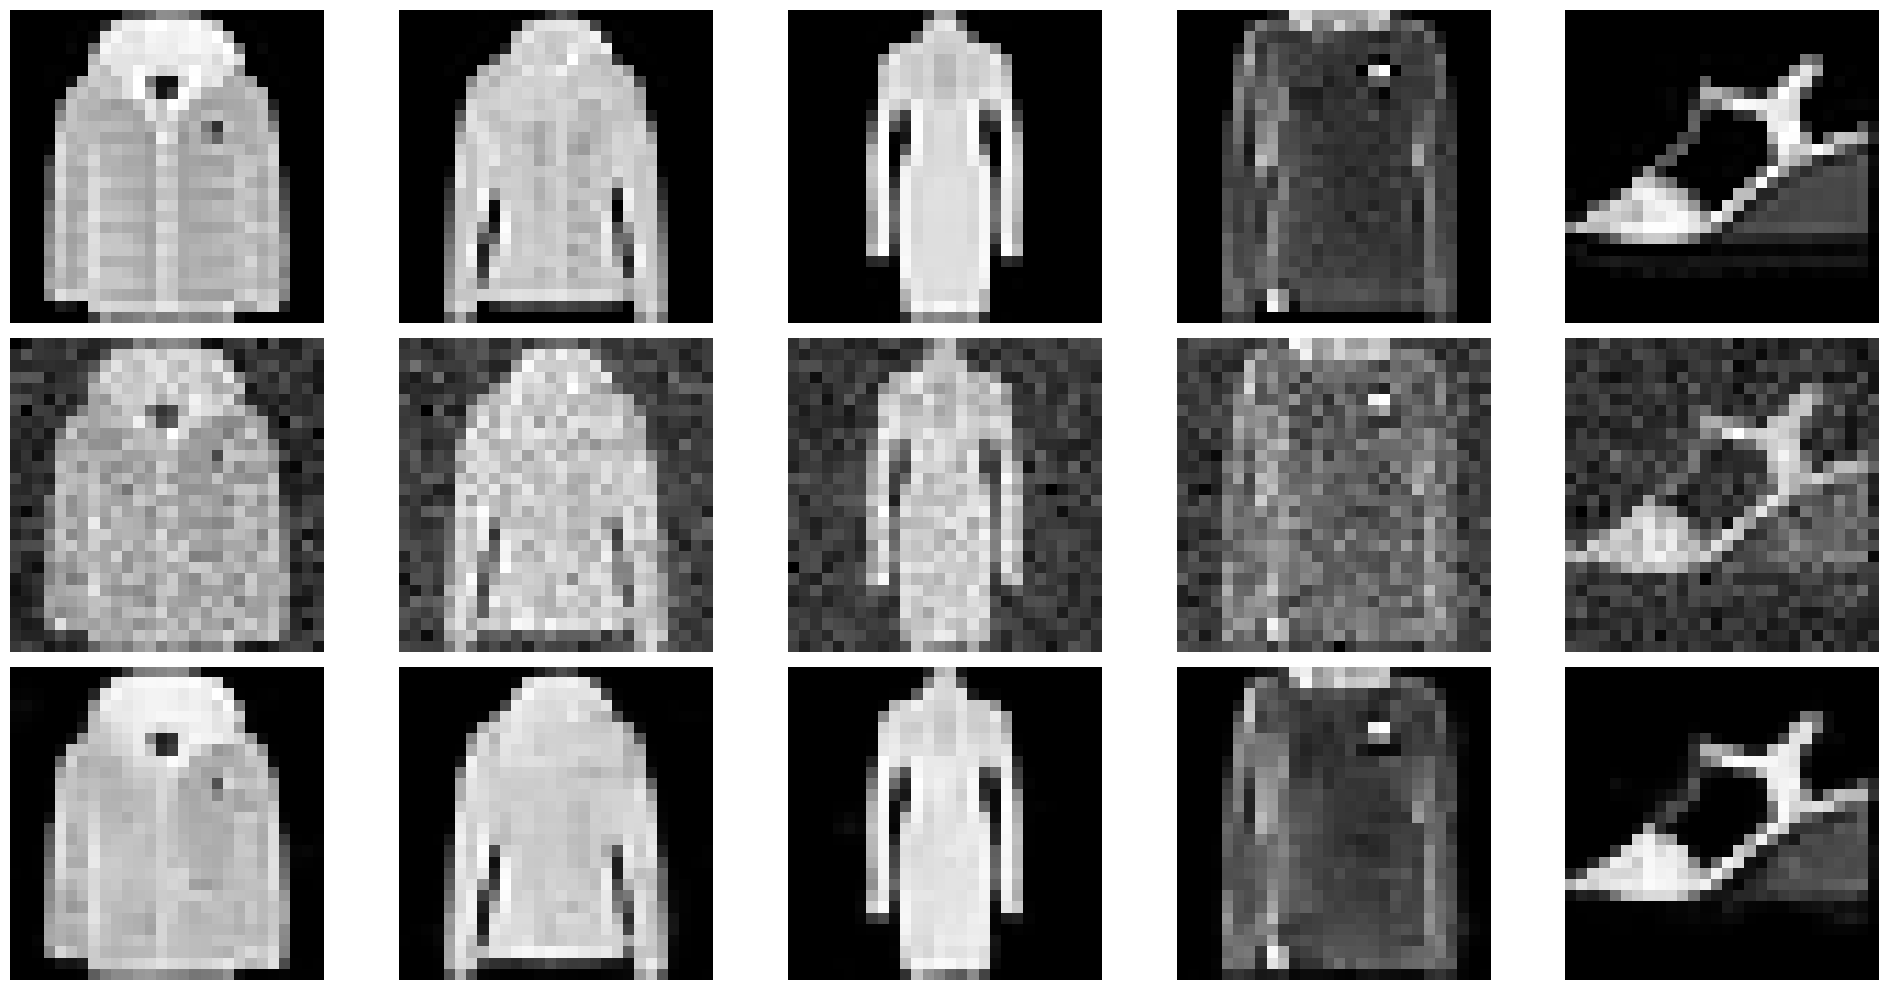

In [238]:
visualize_denoising_examples(amount=5, model=model_denoise, dataset=train_dataset_noisy)

# Task 3: Model Selection

Conduct at least **3 experiments** for **each** of the previous tasks and document them (i.e. at least 6 experiments).  
Evaluate the effect of different parameters on the classification and denoising tasks.  
Conduct the following experiments:
- Evaluate the effect of residual connections
- Evaluate the effect of the depth(number of layers)/width (number of channels or number of neurons) of the network  
- Evaluate the effect of Batch normalization

## Optional experiments:
- How does the loss function affect denoising? Alternative loss functions: MSE, MAE, SSIM?
- How does Dropout affect the performance?
- Use different downsampling/upsampling layers, e.g.pooling, strided convolution, transposed convolution, etc.  
- Feel free to explore more variations of your model and training.